## How does a neural net really work

In this notebook I'm exploring fast.ai's Kaggle notebook on ["How does a neural net really work"](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work). This relates to [Lesson 3 of the fast.ai Deep Learning course](https://course.fast.ai/Lessons/lesson3.html). While the video provides a solid explanation, the enigmatic imports and variables can be difficult to comprehend. I'm reimplementing some sections to see if if sticks. In a nutshell, this is what is happening in this notebook:

1. Revising Regressions  
   - Plot a generic quadratic function ($ax^2 + bx + c$)  
   - Generate some random data points  
   - Learn the step-by-step process to find the values of `a`, `b`, and `c` that make our function represent the random data generated in `2`  
   - Use the [mean absolute error](https://docs.fast.ai/metrics.html#mae) to manually adjust `a`, `b`, and `c`.  
2. Understand and break down the Gradient Descent algorithm
3. The Basics of a Neural-Network
   - Understand what is a ReLU
   - Create the simplest neural-network possible

In [1]:
# Installing the dependencies within the notebook to make it easier to run on colab
%pip install -Uqq fastai ipywidgets plotly

Note: you may need to restart the kernel to use updated packages.


## 1. Revising Regressions

### 1.1 Plot a generic quadratic function ($ax^2+bx+c$)

In [2]:
from fastai.basics import torch, plt

# Set the figure DPI to 90 for better resolution
plt.rc('figure', dpi=90)

# Function to plot a mathematical function over a range
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    # Create evenly spaced x values as a column vector
    x = torch.linspace(min,max, 100)[:,None]
    # Set y-axis limits if specified
    if ylim: plt.ylim(ylim)
    # Plot the function
    plt.plot(x, f(x), color)
    # Add title if provided
    if title is not None: plt.title(title)

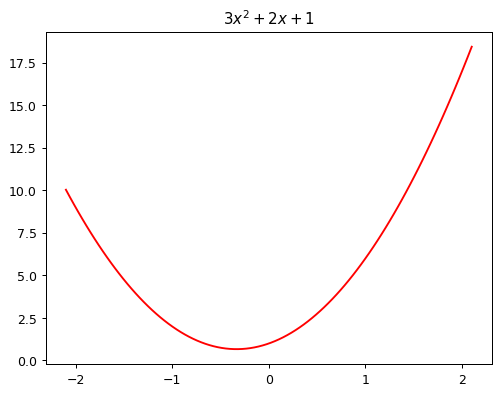

In [3]:
# Function with quadratic expression ax^2 + bx + c
def quad(a, b, c, x): return a*x**2 + b*x + c

from functools import partial
# Creates a new function with fixed a,b,c parameters, leaving only x variable
# This allows us to create specific quadratic functions by "fixing" the coefficients
def mk_quad(a,b,c): return partial(quad, a,b,c)

def demo_plot_basic_quadratic():
    a = 3
    b = 2
    c = 1
    f = mk_quad(a, b ,c)
    plot_function(f, title=f'${a}x^2 + {b}x + {c}$')

demo_plot_basic_quadratic()

### 1.2. Generate some random data points

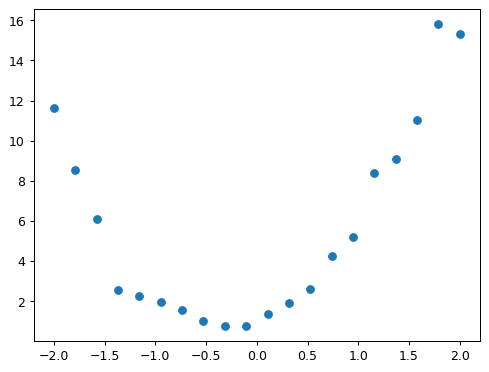

In [4]:
# Add both multiplicative and additive noise to input x
def add_noise(x, mult, add): return x * (1+torch.randn(x.shape) * mult) + torch.randn(x.shape) * add

def generate_noisy_data(f, x_start=-2, x_end=2, num_datapoints=20, noise_mult=0.15, noise_add=0.15, seed=42):
    # Define a static seed, so that the random data is always the same every time we run this
    torch.manual_seed(seed)
    # Create evenly spaced x values and add a dimension of size 1 at position 1,
    # transforming shape from (20,) to (20,1) to make it a column vector
    # Example: tensor([1,2,3]) shape=(3,)  ->  tensor([[1],[2],[3]]) shape=(3,1)
    x = torch.linspace(x_start, x_end, steps=num_datapoints).unsqueeze(1) 
    # Generate noisy y values by applying noise to function output
    # mult=0.15 for multiplicative noise, add=1.5 for additive noise
    y = add_noise(f(x), noise_mult, noise_add)
    return x, y

def demp_plot_random_data():
   x,y = generate_noisy_data(mk_quad(3,2,1))
   plt.scatter(x,y);

demp_plot_random_data()

### 1.3. Fit the function to the data

In this section, we will explore the step-by-step process to find the values of `a`, `b`, and `c` that allow our function to accurately reflect the random data generated in `1.2`. The interactive plot below, shows how adjustments to `a`, `b`, and `c` influence the function's shape to better align with our data layout.

In [5]:
from ipywidgets import interact
@interact(a=1.5, b=1.5, c=1.5)
def demo_interactive_plot_quad(a, b, c):
    plt.close('all')  # Close all existing figures
    plt.figure()      # Create a new figure
    x,y = generate_noisy_data(mk_quad(3,2,1))
    
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(0,13))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

### 1.4 Measure the error

This is cool and works, but we need to know how close we are to our ideal solution. In regression, we can use fun ways to estimate this, like the "Mean Absolute Error," which averages the distance between predicted and actual values.

The [fastai library has a wrapper for some of the most common methods](https://docs.fast.ai/metrics.html#regression) (from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)).

Here's a quick demo where we can see how it is calculated.

In [6]:
def mean_absolute_error(preds, acts): return (torch.abs(preds-acts)).mean()

def demo_mean_absolute_error():
    # Create some example predictions and actual values
    preds = torch.tensor([1.0, 2.0, 3.0, 4.0])
    actuals = torch.tensor([1.1, 2.1, 2.8, 4.2])

    # Calculate and print the mean absolute error
    error = mean_absolute_error(preds, actuals)
    print(f"Mean Absolute Error: {error:.3f}")

    # Let's break down what's happening:
    print("\nAbsolute differences between predictions and actuals:")
    abs_diffs = torch.abs(preds-actuals)
    for i, (p, a, d) in enumerate(zip(preds, actuals, abs_diffs)):
        print(f"Prediction: {p:.1f}, Actual: {a:.1f}, Absolute Difference: {d:.3f}")

demo_mean_absolute_error()

Mean Absolute Error: 0.150

Absolute differences between predictions and actuals:
Prediction: 1.0, Actual: 1.1, Absolute Difference: 0.100
Prediction: 2.0, Actual: 2.1, Absolute Difference: 0.100
Prediction: 3.0, Actual: 2.8, Absolute Difference: 0.200
Prediction: 4.0, Actual: 4.2, Absolute Difference: 0.200


In [7]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    x,y = generate_noisy_data(mk_quad(3,2,1))

    f = mk_quad(a, b ,c)
    plt.scatter(x,y)
    loss = mean_absolute_error(f(x), y)
    plot_function(f, ylim=(0,13), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

## 2. Understand and break down the Gradient Descent algorithm

Now that we can calculate the mean absolute error, the next step is to understand how to adjust our parameters `a`, `b`, and `c` to *reduce* this error.  To do this, we can think about the *gradients* of the error with respect to each of the `a,b,c` parameters.

👉 If you were walking on a hill (representing the error surface), the partial derivative with respect to one direction (say, the 'a' direction) tells you the slope of the hill in *that specific direction*.  A steep *slope/gradient* means a large change in error for a small change in 'a'.

For example, if we consider the partial derivative of the mean absolute error with respect to `a` (while keeping `b` and `c` fixed), a negative value would indicate that increasing `a` will lead to a *decrease* in the error (like walking forward-downhill in the 'a' direction). Conversely, a positive value would suggest that decreasing `a` would reduce the error (ackwardly walking backwards-downhill in the 'a' direction 😄).  


---

Using AI, we can plot this hill. The following plot shows the "error surface" (MAE) for the function $f(x) = m*x + b$. By fixing one variable (e.g., `b=2`), we can visualize the differentiated function in terms of `m` and determine whether to increase or decrease `m` to move "downhill."

In [8]:
import plotly.graph_objects as go

def demo_mae_surface():
    # Actual data points
    x_actual = torch.tensor([1.0, 2.0])
    y_actual = torch.tensor([2.0, 4.0])

    # Range of m and b values to explore
    m_vals = torch.linspace(-1, 5, 100) # Explore m from -1 to 5
    b_vals = torch.linspace(-1, 5, 100) # Explore b from -1 to 5

    # Create a meshgrid of m and b values
    M, B = torch.meshgrid(m_vals, b_vals, indexing='ij')

    # Initialize an array to store MAE values for the surface plot
    mae_values_surface = torch.zeros_like(M)

    # Calculate MAE for each combination of m and b for the surface plot
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            m = M[i, j]
            b = B[i, j]
            preds = m * x_actual + b
            mae = mean_absolute_error(preds, y_actual)
            mae_values_surface[i, j] = mae.item() # Store the scalar value

    # --- Calculate MAE for fixed b to show gradient of m ---
    fixed_b = 2.0 # Fixed b value
    mae_values_fixed_b = []
    for m in m_vals:
        preds = m * x_actual + fixed_b
        mae = mean_absolute_error(preds, y_actual)
        mae_values_fixed_b.append(mae.item())


    # Create the surface plot using Plotly
    fig = go.Figure(data=[go.Surface(z=mae_values_surface.numpy(), x=b_vals.numpy(), y=m_vals.numpy(), colorscale='RdBu', name='MAE Surface')])

    # Add the line plot for fixed b, offsetting z values slightly
    z_offset_line = 0.1  # Offset to lift the line above the surface
    fig.add_trace(go.Scatter3d(
        x=[fixed_b] * len(m_vals), # Fixed b value for all m values
        y=m_vals.numpy(),
        z=[z + z_offset_line for z in mae_values_fixed_b], # Add offset to z values
        mode='lines',
        line=dict(color='green', width=4),
        name=f'MAE with fixed b={fixed_b}'
    ))

    # Add annotation - Adjusted for better readability, offsetting z value slightly
    annotation_m = 2.0
    annotation_mae = mean_absolute_error(annotation_m * x_actual + fixed_b, y_actual).item()
    z_offset_point = 0.1 # Offset to lift the point above the surface
    fig.add_trace(go.Scatter3d(
        x=[fixed_b],
        y=[annotation_m],
        z=[annotation_mae + z_offset_point], # Add offset to z value
        mode='markers+text',
        marker=dict(size=8, color='red'),
        text=["At m=2, decrease m to go dowhill"], # Shortened text
        textposition="top center", # Changed text position to top center
        textfont=dict(size=10) # Reduced text size
    ))


    fig.update_layout(
        title='3D Error Surface: Mean Absolute Error (MAE) for f(x) = mx + b<br>with line showing gradient of m at fixed b=2', # Added <br> for title wrapping
        scene=dict(
            xaxis_title='b (y-intercept)',
            yaxis_title='m (slope)',
            zaxis_title='MAE',
            camera=dict(eye=dict(x=1.5, y=-1.5, z=0.8)) # Rotate perspective
        ),
        width=700,
        height=700
    )


    fig.show()

demo_mae_surface()


With PyTorch, we can use `require_grad=True` on tensors, which automatically handles differentiation and the calculation of the gradients for us. To be honest, it looks a bit like dark magic. Let's look at some examples where we can see this functionality from PyTorch being applied to our function $f(x) = m*x + b$, along with two different inputs (`x1` and `x2`)🕵️‍♂️.

In [9]:
#########################################
# Example 1: Using x1 = [1.0, 2.0, 3.0]
#########################################
x1 = torch.tensor([1.0, 2.0, 3.0])
m1 = torch.tensor(2.0, requires_grad=True)
b1 = torch.tensor(1.0, requires_grad=True)

# Compute f(x1) = m1 * x1 + b1
y1 = m1 * x1 + b1
total1 = y1.sum()  # total1 = m1*(1+2+3) + b1*3 = 6*m1 + 3*b1

# Compute gradients for m1 and b1.
total1.backward()

print(f'Example 1 | x: {x1}, m: {m1}, b: {b1}')
print("Example 1 | Gradient with respect to m1 (m1.grad):", m1.grad)  # Expected: sum(x1) = 6.0
print("Example 1 | Gradient with respect to b1 (b1.grad):", b1.grad)  # Expected: len(x1) = 3
print("--------------")

#########################################
# Example 2: Using x2 = [1.0, 4.0] (different size and values)
#########################################
x2 = torch.tensor([1.0, 4.0])
m2 = torch.tensor(2.0, requires_grad=True)
b2 = torch.tensor(1.0, requires_grad=True)

# Compute f(x2) = m2 * x2 + b2
y2 = m2 * x2 + b2
total2 = y2.sum()  # total2 = m2*(1+4) + b2*2 = 5*m2 + 2*b2

# Compute gradients for m2 and b2.
total2.backward()

print(f'Example 2 | x: {x2}, m: {m2}, b: {b2}')
print("Example 2 | Gradient with respect to m2 (m2.grad):", m2.grad)  # Expected: sum(x2) = 5.0
print("Example 2 | Gradient with respect to b2 (b2.grad):", b2.grad)  # Expected: len(x2) = 2
print("--------------")

# Print an explanation that details the differentiation steps.
explanation = """
Explanation:
- **Example 1:**
   - We start with a list of numbers: x1 = [1.0, 2.0, 3.0].
   - We plug each number into our function, which means we multiply it by m (let's say m = 2) and then add b (let's say b = 1):
     - For 1.0: f(1.0) = 2 * 1 + 1 = 3
     - For 2.0: f(2.0) = 2 * 2 + 1 = 5
     - For 3.0: f(3.0) = 2 * 3 + 1 = 7
   - So, we end up with y1 = [3.0, 5.0, 7.0].
   - Then, we add these numbers together: 3 + 5 + 7 = 15.
   - If we look at our equation, we can say: total1 = m1*(1.0+2.0+3.0) + b1*3 = 6 * m1 + 3 * b1.
   - Now, when we want to see how changing m1 and b1 affects total1, we find:
     - Changing m1 gives us a "gradient" of 6.
     - Changing b1 gives us a "gradient" of 3.
   - So, m1.grad = 6.0 and b1.grad = 3.

- **Example 2:**
   - Now we have a different list: x2 = [1.0, 4.0].
   - We use the same m and b:
     - For 1.0: f(1.0) = 3 (same as before).
     - For 4.0: f(4.0) = 2 * 4 + 1 = 9.
   - So, now we have y2 = [3.0, 9.0].
   - We add these: 3 + 9 = 12.
   - In terms of our equation, total2 = m2*(1.0+4.0) + b2*2 = 5 * m2 + 2 * b2.
   - For the gradients:
     - Changing m2 gives us a "gradient" of 5.
     - Changing b2 gives us a "gradient" of 2.
   - So, m2.grad = 5.0 and b2.grad = 2.
"""
print(explanation)



Example 1 | x: tensor([1., 2., 3.]), m: 2.0, b: 1.0
Example 1 | Gradient with respect to m1 (m1.grad): tensor(6.)
Example 1 | Gradient with respect to b1 (b1.grad): tensor(3.)
--------------
Example 2 | x: tensor([1., 4.]), m: 2.0, b: 1.0
Example 2 | Gradient with respect to m2 (m2.grad): tensor(5.)
Example 2 | Gradient with respect to b2 (b2.grad): tensor(2.)
--------------

Explanation:
- **Example 1:**
   - We start with a list of numbers: x1 = [1.0, 2.0, 3.0].
   - We plug each number into our function, which means we multiply it by m (let's say m = 2) and then add b (let's say b = 1):
     - For 1.0: f(1.0) = 2 * 1 + 1 = 3
     - For 2.0: f(2.0) = 2 * 2 + 1 = 5
     - For 3.0: f(3.0) = 2 * 3 + 1 = 7
   - So, we end up with y1 = [3.0, 5.0, 7.0].
   - Then, we add these numbers together: 3 + 5 + 7 = 15.
   - If we look at our equation, we can say: total1 = m1*(1.0+2.0+3.0) + b1*3 = 6 * m1 + 3 * b1.
   - Now, when we want to see how changing m1 and b1 affects total1, we find:
     - 

Now we can create an interactive plot where we show the gradient on `a`, `b` and `c`. 
If the slope is negative we want to move forward (or downhill).

In [10]:
@interact(a=1.5, b=1.5, c=1.5)
def demo_quadratic_plot_with_gradients(a, b, c):
    x,y = generate_noisy_data(mk_quad(3,2,1))
    plt.scatter(x,y)

    a_tensor = torch.tensor([float(a)], requires_grad=True)
    b_tensor = torch.tensor([float(b)], requires_grad=True)
    c_tensor = torch.tensor([float(c)], requires_grad=True)

    f = mk_quad(a_tensor, b_tensor, c_tensor)

    loss =  torch.abs(f(x) - y).mean() 
    loss.backward()

    a_grad = a_tensor.grad.item()
    b_grad = b_tensor.grad.item()
    c_grad = c_tensor.grad.item()

    plot_function(lambda x: f(x).detach(), ylim=(0,13), title=f"MAE: {loss:.2f}, dLoss/da: {a_grad:.2f}, dLoss/db: {b_grad:.2f}, dLoss/dc: {c_grad:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [11]:
from fastai.metrics import mae

def demo_auto_fit(steps=50):
    x, y = generate_noisy_data(mk_quad(3,2,1))

    abc = torch.tensor([1.0,1.0,1.0], requires_grad=True)
    min_loss = float('inf')
    best_abc = abc.clone().detach() # Initialize best_abc with the initial abc

    for i in range(steps):
        f = mk_quad(*abc)
        loss = mae(f(x), y)
        loss.backward()

        with torch.no_grad():
            abc -= abc.grad*0.1
            abc.grad.zero_() # Clear gradients after update

        print(f'step={i}; loss={loss.item():.2f}; abc={abc}')

        if loss < min_loss:
            min_loss = loss
            best_abc = abc.clone().detach() # Update best_abc when a lower loss is found

    return best_abc

best_abc_params = demo_auto_fit()
print(f"Best abc parameters: {best_abc_params}")

step=0; loss=3.15; abc=tensor([1.1463, 1.0042, 1.0800], requires_grad=True)
step=1; loss=2.87; abc=tensor([1.2925, 1.0084, 1.1600], requires_grad=True)
step=2; loss=2.59; abc=tensor([1.4388, 1.0126, 1.2400], requires_grad=True)
step=3; loss=2.32; abc=tensor([1.5634, 1.0347, 1.2900], requires_grad=True)
step=4; loss=2.14; abc=tensor([1.6881, 1.0568, 1.3400], requires_grad=True)
step=5; loss=1.96; abc=tensor([1.7993, 1.0905, 1.3800], requires_grad=True)
step=6; loss=1.81; abc=tensor([1.9016, 1.1337, 1.4100], requires_grad=True)
step=7; loss=1.69; abc=tensor([1.9975, 1.1811, 1.4200], requires_grad=True)
step=8; loss=1.57; abc=tensor([2.0933, 1.2284, 1.4300], requires_grad=True)
step=9; loss=1.46; abc=tensor([2.1864, 1.2705, 1.4300], requires_grad=True)
step=10; loss=1.36; abc=tensor([2.2794, 1.3126, 1.4300], requires_grad=True)
step=11; loss=1.26; abc=tensor([2.3725, 1.3547, 1.4300], requires_grad=True)
step=12; loss=1.15; abc=tensor([2.4656, 1.3968, 1.4300], requires_grad=True)
step=13; 